# Part 4 - Exercise: Regression toy problem

In this exercise, you are presented with a simple regression problem. 
Your task is to write your first script to learn a model of the data.
Feel free to use code of the previous tutorials and adjust it where necessary.

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

## Hyperparams & constants

In [2]:
dim_in, dim_out = 1, 1
dims_hidden = [32, 32]
activations_hidden = ["tanh", "tanh"]
batch_size = 16
learning_rate = 5e-3

num_iterations_train = 20000

## Data

In [4]:
def some_function(x):
    return np.sin(np.square(x)*2*np.pi) / x

In [5]:
num_samples = 1000
noise_std = 0.25
np.random.seed(seed=42)

# Let's create some dataset of a deterministic function + gaussian noise.
x_train = np.expand_dims(np.random.uniform(low=-1.5, high=1.5, size=num_samples), axis=-1)
y_train = some_function(x_train) + np.random.normal(loc=0, scale=noise_std, size=[num_samples, 1])

x_test = np.expand_dims(np.linspace(-1.5, 1.5, 1000), axis=-1)
y_test = some_function(x_test)

Text(0.5,1,'noise-free test data')

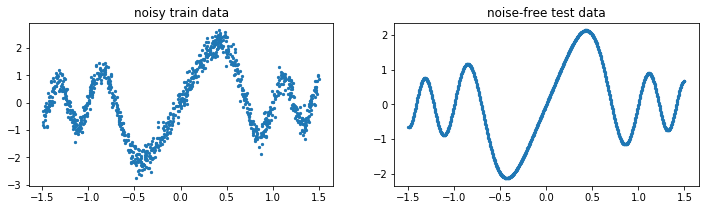

In [6]:
fig, axs = plt.subplots(1, 2, figsize=[12, 3])
axs[0].scatter(x_train, y_train, s=5)
axs[0].set_title("noisy train data")
axs[1].scatter(x_test, y_test, s=5)
axs[1].set_title("noise-free test data")

## Model

In [7]:
class MLP():
    """ Multi-Layer-Perceptron """
    def __init__(self, name: str, dim_in: int, dims: tuple, activations: tuple):
        self.name = name
        self.dim_in = dim_in
        self.dim_out = dims[-1]
        self.shp_in = (dim_in,)
        self.shp_out = (dims[-1],)
        
        dims_in = (dim_in,) + tuple(dims[:-1])
        dims_out = dims
        self.layers = list()
        with tf.variable_scope(name, reuse=False): 
            for idx_hidden, (dim_in, dim_out, activation) in enumerate(zip(dims_in, dims_out, activations)):
                kernel_initializer, bias_initializer = self.get_initializers_for(activation=activation)
                # ***********************************
                layer = tf.keras.layers.Dense(dim_out, 
                                              activation=activation, 
                                              name="layer_{}".format(idx_hidden), 
                                              kernel_initializer=kernel_initializer, 
                                              bias_initializer=bias_initializer,
                                             )
                layer.build(dim_in)
                # ***********************************
                self.layers.append(layer)

    def __call__(self, x):
        h = x
        for layer in self.layers:
            h = layer(h)
        return h
    
    def get_initializers_for(self, activation: str, distribution: str = "uniform", mode : str = "fan_in"):
        """ Helper function to choose appropriate initialization method, depending on the activation function. """
        if not isinstance(activation, str):
            activation = activation.__name__

        if activation in [None, 'linear']:
            scale = 1.0
        elif activation is "relu":
            scale = 2.0  
        elif activation is "tanh":
            scale = 1.32
        else:
            raise ValueError("unexpected activation function: {}".format(activation))

        kernel_initializer = tf.initializers.variance_scaling(
            scale=scale,
            mode=mode,
            distribution=distribution,
        )
        bias_initializer = tf.initializers.constant(0.0)
        return kernel_initializer, bias_initializer

In [8]:
tf.reset_default_graph()  # Might be helpful, if you rebuild your model.

targets = tf.placeholder(shape=[None, dim_out], dtype=tf.float32, name="targets")  
inputs = tf.placeholder(shape=[None, dim_in], dtype=tf.float32, name="inputs")
model = MLP(name="MLP", 
            dim_in=dim_in, 
            dims=dims_hidden + [dim_out],  # last dimension is for output layer.
            activations=activations_hidden + ["linear"],  # Output has no activation function.
           )
outputs = model(inputs) 

**Note:** I strongly recommend to use tf.distributions. 
This way, you are explicit about your assumptions about the data distribution. 
Furthermore, your loss function directly follows from this assumption, i.e. your objective is to maximize the log-likelihood $\log p_{\theta}(y ~|~ x)$, where $\theta$ are the model parameters (variables in tensorflow). 

In [9]:
def get_loglikelihood(loc, targets):
    likelihood_dist = tf.distributions.Normal(
        loc=loc, scale=noise_std, name="predictions")  
    with tf.name_scope("log-likelihood"):
        loglikelihood = tf.reduce_sum(likelihood_dist.log_prob(targets))  
    return loglikelihood

In [10]:
loss = - get_loglikelihood(outputs, targets)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

In [11]:
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
sess = tf.Session()
sess.run(tf.global_variables_initializer()) # Initializes weights and biases.

In [12]:
best_val_accuracy = -np.inf
for iter_train in range(num_iterations_train):  
    #*****************************************
    indices = np.random.random_integers(low=0, high=len(x_train) - 1, size=batch_size)
    batch_inputs, batch_targets = x_train[indices], y_train[indices]
    #*****************************************
    feed_dict = {inputs: batch_inputs, targets: batch_targets}
    _, train_loss = sess.run([train_step, loss], feed_dict=feed_dict)

/Users/Richard/.virtualenvs/tf_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 999 + 1) instead
  after removing the cwd from sys.path.


In [13]:
predictions_train = sess.run(outputs, feed_dict={inputs: x_train})
predictions_test = sess.run(outputs, feed_dict={inputs: x_test})

Text(0.5,1,'noise-free test data')

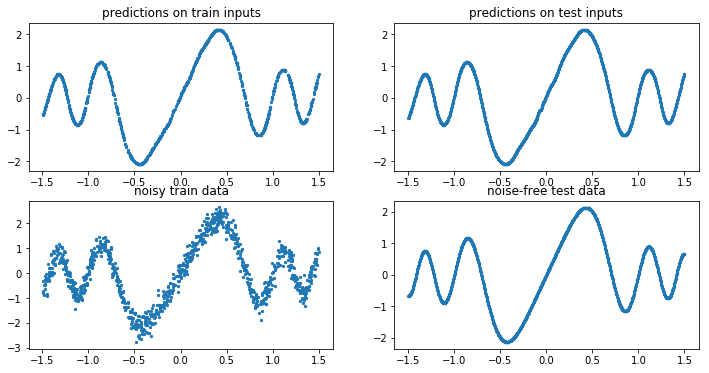

In [14]:
fig, axs = plt.subplots(2, 2, figsize=[12, 6])

axs[0, 0].scatter(x_train, predictions_train, s=5)
axs[0, 0].set_title("predictions on train inputs")
axs[0, 1].scatter(x_test, predictions_test, s=5)
axs[0, 1].set_title("predictions on test inputs")

axs[1, 0].scatter(x_train, y_train, s=5)
axs[1, 0].set_title("noisy train data")
axs[1, 1].scatter(x_test, y_test, s=5)
axs[1, 1].set_title("noise-free test data")

## Some things to try out...

- Evaluate the model on a larger input range (e.g. -2.5 ... 2.5). What do you observe?
- Overparametrize the model (e.g. hidden layers [128, 128])
- Try ReLU
- Try other learning rates or optimizers (e.g. plain GradientDescent, Momentum)